# How 'rigorous' is the philosophy literature on Effective Altruism (EA)?

A first college try

Aug 14, 2025

[I made a comment in a forum](https://forum.effectivealtruism.org/posts/d4qcWisHZA2XtASJX/the-effective-altruism-community-inherits-the-problems-of?commentId=zeK94LfySZo7jWxCC) supporting the claim that Effective Altruism (EA) philsophy literature lacks rigor due to insularity. Someone made a wonderful counter saying EA literature is published in top philosophy journals which makes my claim suspect. I thought, "Oh snap! Thats it! Thats the empirical angle here! Why didn't I think of this first? The OP literally had charts and I should've made my own." And thus we are here. I want to assess the feasibility of a project to measure how good Effective Altruism is in the context of the rest of philosophy and academic lit as a whole. It should probably also measure something like "interdisciplinarity" because that is the part I am mostly critical about. 

Keep all that aside for now because it requires some litrev legwork. before doing that work, lets just look for papers with "Effective Altruism" in the title+abstract and see if something is even there to do worthwile work here.

## The dataset

I am going to use [OpenAlex](https://openalex.org/) because I am using it for another project, and I have already done the legwork to create a local version of the whole database in my dept's server (See [my other repo](https://github.com/VenkiPhy6/oalexdump) if you want to create a local version for yourself). The [OpenAlex website](https://help.openalex.org/hc/en-us/articles/24396686889751-About-us) describes the dataset as "...a catalog of works. A work is any sort of scholarly output. A research article is one kind of work, but there are others such as datasets, books, and dissertations. We keep track of these works—their titles (and abstracts and full text in many cases), when they were created, etc. But that's not all we do. We also keep track of the connections between these works, finding associations through things like journals, authors, institutional affiliations, citations, concepts, and funders. ..." So it contains research across all disciplines. The website also lists their sources - "Currently (as of January 2025), the list of core sources we pull this type of information includes Crossref, DataCite, PubMed, HAL, DOAJ, ORCID, MAG, arXiv, Dergipark, OSTI, RePEc, UNC Carolina, University of Michigan Deep Blue, Zenodo, ISSN, other institutional repositories (full list), parsing of 60M open access PDFs, some journal landing pages, directly from some publishers, and from our users through community curation requests. We're working on a significant rewrite to the OpenAlex guts code that will enable us to add many new core sources starting in March 2025." I hope that gives you an idea of what is in this dataset. They are open source and have their code up on [this repository](https://github.com/ourresearch) but I haven't read any of it.

The other neat thing about OpenAlex is the ML classification of topics of those scholarly outputs. You can read more about it on [the OpenAlex docs](https://docs.openalex.org/api-entities/topics). From what I've heard this is a good starting point, but of course you'd need to do some of your stuff. LLMs are cheap in 2025 and so this shouldn't stand in the way. From personal experience one thing that I know is bad is the institutional affiliations. I know that the institution strings are untidy but its not uncleanable. In a sample I was focussing on, I saw that the fill rate of institutional affiliations was also bad but that may not be true in general.

Throughout the rest of the code, I will be using a local version of the database that I have on my machine. But it is also available via [the OpenAlex API](https://docs.openalex.org/how-to-use-the-api/api-overview). It should be possible for you to 'mostly' replicate the numbers I provide below. I say 'mostly' because I loaded the data in December 2024 and haven't updated. So if there are newer publications since Jan 2025 I may have missed those. But I don't think there was a seismic shift in EA lit during that time and so the results shouldn't change substantively even if you use the API to pull the latest data.

## Method

With the dataset and a motivation clear, what do I want to check here? The big question is - what is the comparison group/coutnerfactual? So EA is less rigourous and less interdisciplinary compared to what exactly? What is a worthwhile comparison here? The OP in the forum post compares it to Econ but is that right? This is question I have to wrestle with throughout this project. Lets start somewhere and see what pops up in a first go as a comparison group

I think implicitly in my rant, I belive that it is less rigorours compared to other philosophy owing to its lack of interdisciplinarity. So at a construct level treatment is something like "Being an a paper in philosophy X". Outcomes are "Interdisciplinarity" and "Rigor". As a first operationalization lets say treatment is 1 if paper contains the phrase "effective altruism" in title/abstract. Then say treatment is 0 if that phrase isn't there but there is a paper in the same OpenAlex topics as those papers that contain that phrase. For now I will not operationalize "Interdisciplinarity" and "Rigor" since it requires some important litrev legwork.

With that clear lets go ahead, make some plots and check feasibility of the treatment measure here.

In [ ]:
import pandas as pd
import duckdb
from os.path import join
import re

In [ ]:
con  = duckdb.connect("./data/eabiblio.duckdb", read_only=False)
oalex_csv_dir = r"D:\oalexdump\csv_files"

In [ ]:
# Getting those works with effective altrusim in title or the words effective and altruism indexed in the abstracted_inverted_index strings.

# con.sql(f"""
#         CREATE TABLE eapubs_stg as 
#         SELECT * FROM read_csv_auto('{join(oalex_csv_dir, 'works.csv.gz')}')
#         WHERE LOWER(title) LIKE '%effective altrusim%' OR LOWER(abstract_inverted_index) LIKE '%effective%altruism%'
#         ;
#         """)

One weirdness in the code above is the `WHERE` clause filter `LOWER(abstract_inverted_index) LIKE '%effective%altruism%'`. The reason I am doing this is because abstracts are not stored as ordinary plaintext in OpenAlex. They are stored as abstract inverted index which is a datatype that stores abstracts in a smarter way reducing storage requirements. This in turn stored as a JSON string in the csv flat files of the database I have in my machine. 

To illustrate, if the paper's abstract is "This is the abstract for this paper" it is stored as the following JSON (or rather as a JSON string in my CSv files): `{"this": [0, 5], "is": [1], "the": [2], "abstract": [3], "for": [4], "paper": [6] }` See how "this" is stored only once with a list of two indices instead of storing it twice? That's how abstract inverted indices save space. With this in mind it should be clear why I did a `'%effective%altruism%'`. 

This is also why I made this as a `_stg` table. Once I subset to a reasonable number of publications, I can pull this more manageable staging table into RAM, turn the abstract inverted index to a proper full text abstract, and then filter again to only those titles/abstracts that contain the exact phrase "effective altruism" instead of "effective [maybe some other words/sentences] altruism" which is what the current filter does. I do this next. 

In [ ]:
#ChatGPT cooked up this neat little function that turns abstracte inverted indices to plain text abstracts
# This runs quite fast for my use case here. But I'd imagine this can be made way faster. Maybe there is even an implementation already out there...

import json

def inverted_index_to_abstract(index_str):
    # Parse the JSON string to a dictionary
    index_dict = json.loads(index_str)
    # Create a list of (word, position) pairs
    word_positions = []
    for word, positions in index_dict.items():
        for pos in positions:
            word_positions.append((pos, word))
    # Sort by position and extract words
    word_positions.sort()
    abstract = [word for pos, word in word_positions]
    return ' '.join(abstract)

In [ ]:
eapubs = con.table('eapubs_stg').df()
eapubs.loc[:, 'ab'] = eapubs.abstract_inverted_index.apply(inverted_index_to_abstract)

In [ ]:
ea_srch_phrase = 'effective altruism'
eapubs.loc[~pd.isna(eapubs.title), 'isea_title'] = eapubs.loc[~pd.isna(eapubs.title)].apply(lambda x: not(pd.isna(re.search(ea_srch_phrase, x['title'].lower()))), axis=1)
eapubs.loc[~pd.isna(eapubs.title), 'isea_ab'] = eapubs.loc[~pd.isna(eapubs.ab)].apply(lambda x: not(pd.isna(re.search(ea_srch_phrase, x['ab'].lower()))), axis=1)
eapubs.loc[:, 'isea'] = (eapubs.isea_title | eapubs.isea_ab)
eapubs = eapubs.loc[eapubs.isea]


In [ ]:
print(any(eapubs.isea_title == False))
print(any(eapubs.isea_ab == False))

True
False


This makes sense. If you have "effective altruism" in your title you definitely have it in the abstract. So an OR on those two conditions leads to all records having the phrase in the abstract. Good!

In [ ]:
# Lets put the cleaned table back in

# con.sql("CREATE TABLE eapubs AS SELECT * FROM eapubs;")

In [ ]:
# Getting OpenAlex topics corresponing to EA papers

# con.sql(f"""
#         CREATE TABLE eatops AS
#         SELECT A.id, B.* 
#         FROM 
#             eapubs A
#         INNER JOIN
#             read_csv_auto('{join(oalex_csv_dir, 'works_topics.csv.gz')}') B
#         ON A.id = B.work_id    
#         ;
#         """)

In [ ]:
# While I have topic IDs I need their description as well. This is available in a Google Sheet maintained by OpenAlex. I will go grab it now. 

# goog_sheetcsv_temp = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv&gid={}'
# SHEET_ID = '1v-MAq64x4YjhO7RWcB-yrKV5D_2vOOsxl4u6GBKEXY8'
# GID = '983250122'
# topics_desc = pd.read_csv(goog_sheetcsv_temp.format(SHEET_ID, GID))
# topics_desc.loc[:, 'topic_id'] = 'https://openalex.org/T' + topics_desc.topic_id.astype('str')
# con.sql("CREATE TABLE tops_desc AS SELECT * FROM topics_desc;")

Next step is to go ahead and pull all the papers in the topics of these EA papers. But lets stop for a second and do some descriptives.



## Descriptives

In [ ]:
desc_phr = "There are {} papers in OpenAlex containing the phrase '{}' either in its abstract/title"
print(desc_phr.format(con.table("eapubs").df().id.drop_duplicates().shape[0], ea_srch_phrase))

There are 235 papers in OpenAlex containing the phrase 'effective altruism' either in its abstract/title


Nice to know. The crucial thing - how many OpenAlex topics do these papers correspond to?

In [ ]:
topics_listing = con.sql("""
        SELECT DISTINCT B.*
        FROM 
            eatops A
        INNER JOIN 
            tops_desc B    
        ON A.TOPIC_ID = B.TOPIC_ID
        ;
        """).df()
topics_listing

,topic_id,topic_name,subfield_id,subfield_name,field_id,field_name,domain_id,domain_name,keywords,summary,wikipedia_url
0,https://openalex.org/T10209,Global Maternal and Child Health,2735,"Pediatrics, Perinatology and Child Health",27,Medicine,4,Health Sciences,Maternal Mortality; Child Mortality; Health Sy...,This cluster of papers focuses on global mater...,https://en.wikipedia.org/wiki/Maternal_and_chi...
1,https://openalex.org/T10270,Blockchain Technology Applications and Security,1710,Information Systems,17,Computer Science,3,Physical Sciences,Blockchain; Internet of Things; Smart Contract...,This cluster of papers explores the integratio...,https://en.wikipedia.org/wiki/Blockchain
2,https://openalex.org/T10376,Suicide and Self-Harm Studies,3203,Clinical Psychology,32,Psychology,2,Social Sciences,Suicide; Suicidal Behavior; Prevention Strateg...,This cluster of papers focuses on the epidemio...,https://en.wikipedia.org/wiki/Suicide
3,https://openalex.org/T10443,Social Policy and Reform Studies,3320,Political Science and International Relations,33,Social Sciences,2,Social Sciences,Welfare State; Political Economy; Social Polic...,This cluster of papers explores the intersecti...,https://en.wikipedia.org/wiki/Welfare_state
4,https://openalex.org/T10517,"Financial Literacy, Pension, Retirement Analysis",1402,Accounting,14,"Business, Management and Accounting",2,Social Sciences,Financial Literacy; Retirement Planning; House...,This cluster of papers explores the importance...,https://en.wikipedia.org/wiki/Financial_literacy
...,...,...,...,...,...,...,...,...,...,...,...
171,https://openalex.org/T14272,Agricultural and Food Production Studies,1106,Food Science,11,Agricultural and Biological Sciences,1,Life Sciences,Food; Agriculture; Nutrition; Sustainability; ...,This cluster of papers covers a wide range of ...,https://en.wikipedia.org/wiki/Agriculture_in_L...
172,https://openalex.org/T14293,Biotechnology and Related Fields,2739,"Public Health, Environmental and Occupational ...",27,Medicine,4,Health Sciences,Health Biotechnology; Global Collaboration; De...,This cluster of papers explores the developmen...,https://en.wikipedia.org/wiki/Global_health
173,https://openalex.org/T14350,"Innovation, Sustainability, Human-Machine Systems",3312,Sociology and Political Science,33,Social Sciences,2,Social Sciences,Interdependence; Sustainability; Climate Chang...,This cluster of papers explores the interconne...,https://en.wikipedia.org/wiki/Interdependence
174,https://openalex.org/T14437,Ethics and Legal Issues in Pediatric Healthcare,2735,"Pediatrics, Perinatology and Child Health",27,Medicine,4,Health Sciences,Pediatric; Medical Ethics; Parental Discretion...,This cluster of papers focuses on the ethical ...,https://en.wikipedia.org/wiki/Pediatric_ethics


In [ ]:
desc_phr = "There are {} papers in OpenAlex containing the phrase '{}' either in its abstract/title\nand these correspond to {} OpenAlex topics."
print(desc_phr.format(con.table("eapubs").df().id.drop_duplicates().shape[0], ea_srch_phrase, topics_listing.topic_id.drop_duplicates().shape[0]))

There are 235 papers in OpenAlex containing the phrase 'effective altruism' either in its abstract/title
and these correspond to 176 OpenAlex topics.


Interesting. Lets keep in mind - for each publciation OpenAlex tags 5 topics related to that paper. This tagging is scored and there is a topic that is most relevant to that paper. So what if I take just the top topic tagged against each paper? Will that look different?

In [ ]:
toptopics_listing = con.sql("""
        SELECT DISTINCT B.*
        FROM 
            (
                SELECT TOPIC_ID, WORK_ID, ROW_NUMBER() OVER (PARTITION BY WORK_ID ORDER BY score DESC) AS RNK 
                FROM eatops
            ) A
        INNER JOIN 
            tops_desc B    
        ON A.TOPIC_ID = B.TOPIC_ID
        WHERE RNK = 1
        ;
        """).df()

In [ ]:
desc_phr = "There are {} papers in OpenAlex containing the phrase '{}' either in its abstract/title\nand they have {} OpenAlex topics as most relevant to them."
print(desc_phr.format(con.table("eapubs").df().id.drop_duplicates().shape[0], ea_srch_phrase, toptopics_listing.topic_id.drop_duplicates().shape[0]))

There are 235 papers in OpenAlex containing the phrase 'effective altruism' either in its abstract/title
and they have 95 OpenAlex topics as most relevant to them.


Do most of the papers actually correspond to only a few of these topics?

In [ ]:
topic_cnts = con.sql("""
        SELECT A.*, B.*
        FROM 
            (
                SELECT 
                    TOPIC_ID, 
                    COUNT(DISTINCT
                                CASE 
                                    WHEN RNK = 1 THEN WORK_ID
                                    ELSE NULL
                                END
                        ) AS ea_wrks_topcnt,
                    COUNT(DISTINCT WORK_ID) AS ea_wrks_cnt
                FROM
                (
                    SELECT TOPIC_ID, WORK_ID, ROW_NUMBER() OVER (PARTITION BY WORK_ID ORDER BY score DESC) AS RNK 
                    FROM eatops
                ) A
                GROUP BY 1    
            ) A
        INNER JOIN
            tops_desc B    
        ON A.TOPIC_ID = B.TOPIC_ID
        ORDER BY ea_wrks_cnt DESC
        ;
        """).df().drop_duplicates()
topic_cnts.to_csv("./data/topics_cnt.csv", index=False)

The commenter mentioned that EA philosophy is published in top journals. Lets check that as well.

In [ ]:
topic_cnts = con.sql("""
        SELECT A.*, B.*
        FROM 
            (
                SELECT 
                    TOPIC_ID, 
                    COUNT(DISTINCT
                                CASE 
                                    WHEN RNK = 1 THEN WORK_ID
                                    ELSE NULL
                                END
                        ) AS ea_wrks_topcnt,
                    COUNT(DISTINCT WORK_ID) AS ea_wrks_cnt
                FROM
                (
                    SELECT TOPIC_ID, WORK_ID, ROW_NUMBER() OVER (PARTITION BY WORK_ID ORDER BY score DESC) AS RNK 
                    FROM eatops
                ) A
                GROUP BY 1    
            ) A
        INNER JOIN
            tops_desc B    
        ON A.TOPIC_ID = B.TOPIC_ID
        ORDER BY ea_wrks_cnt DESC
        ;
        """).df().drop_duplicates()
topic_cnts.to_csv("./data/topics_cnt.csv", index=False)

In [ ]:
# con.sql(f"""
#         CREATE TABLE eapublocs AS
#         SELECT A.work_id, A.source_id, B.*
#         FROM 
#             eapubs C
#         INNER JOIN
#             read_csv_auto('{join(oalex_csv_dir, 'works_primary_locations.csv.gz')}') A
#         ON C.id = A.work_id
#         INNER JOIN
#             read_csv_auto('{join(oalex_csv_dir, 'sources.csv.gz')}') B
#         ON A.source_id = B.id
#         ;""")

In [ ]:
jounr_cnts = con.sql("""
        SELECT display_name, COUNT(DISTINCT WORK_ID) ea_wrks_cnt
        FROM eapublocs
        GROUP BY 1
        ;
        ;
        """).df().drop_duplicates()
jounr_cnts.to_csv("./data/journ_cnt.csv", index=False)

Now lets visualize this. I like doing this stuff in R. So quickly shift to R kernel for a while here...

In [ ]:
#THIS IS IN R NOT PYTHON!!!!
options(repr.plot.res = 310, repr.plot.width = 15)
rm(list=ls())
library(ggplot2)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


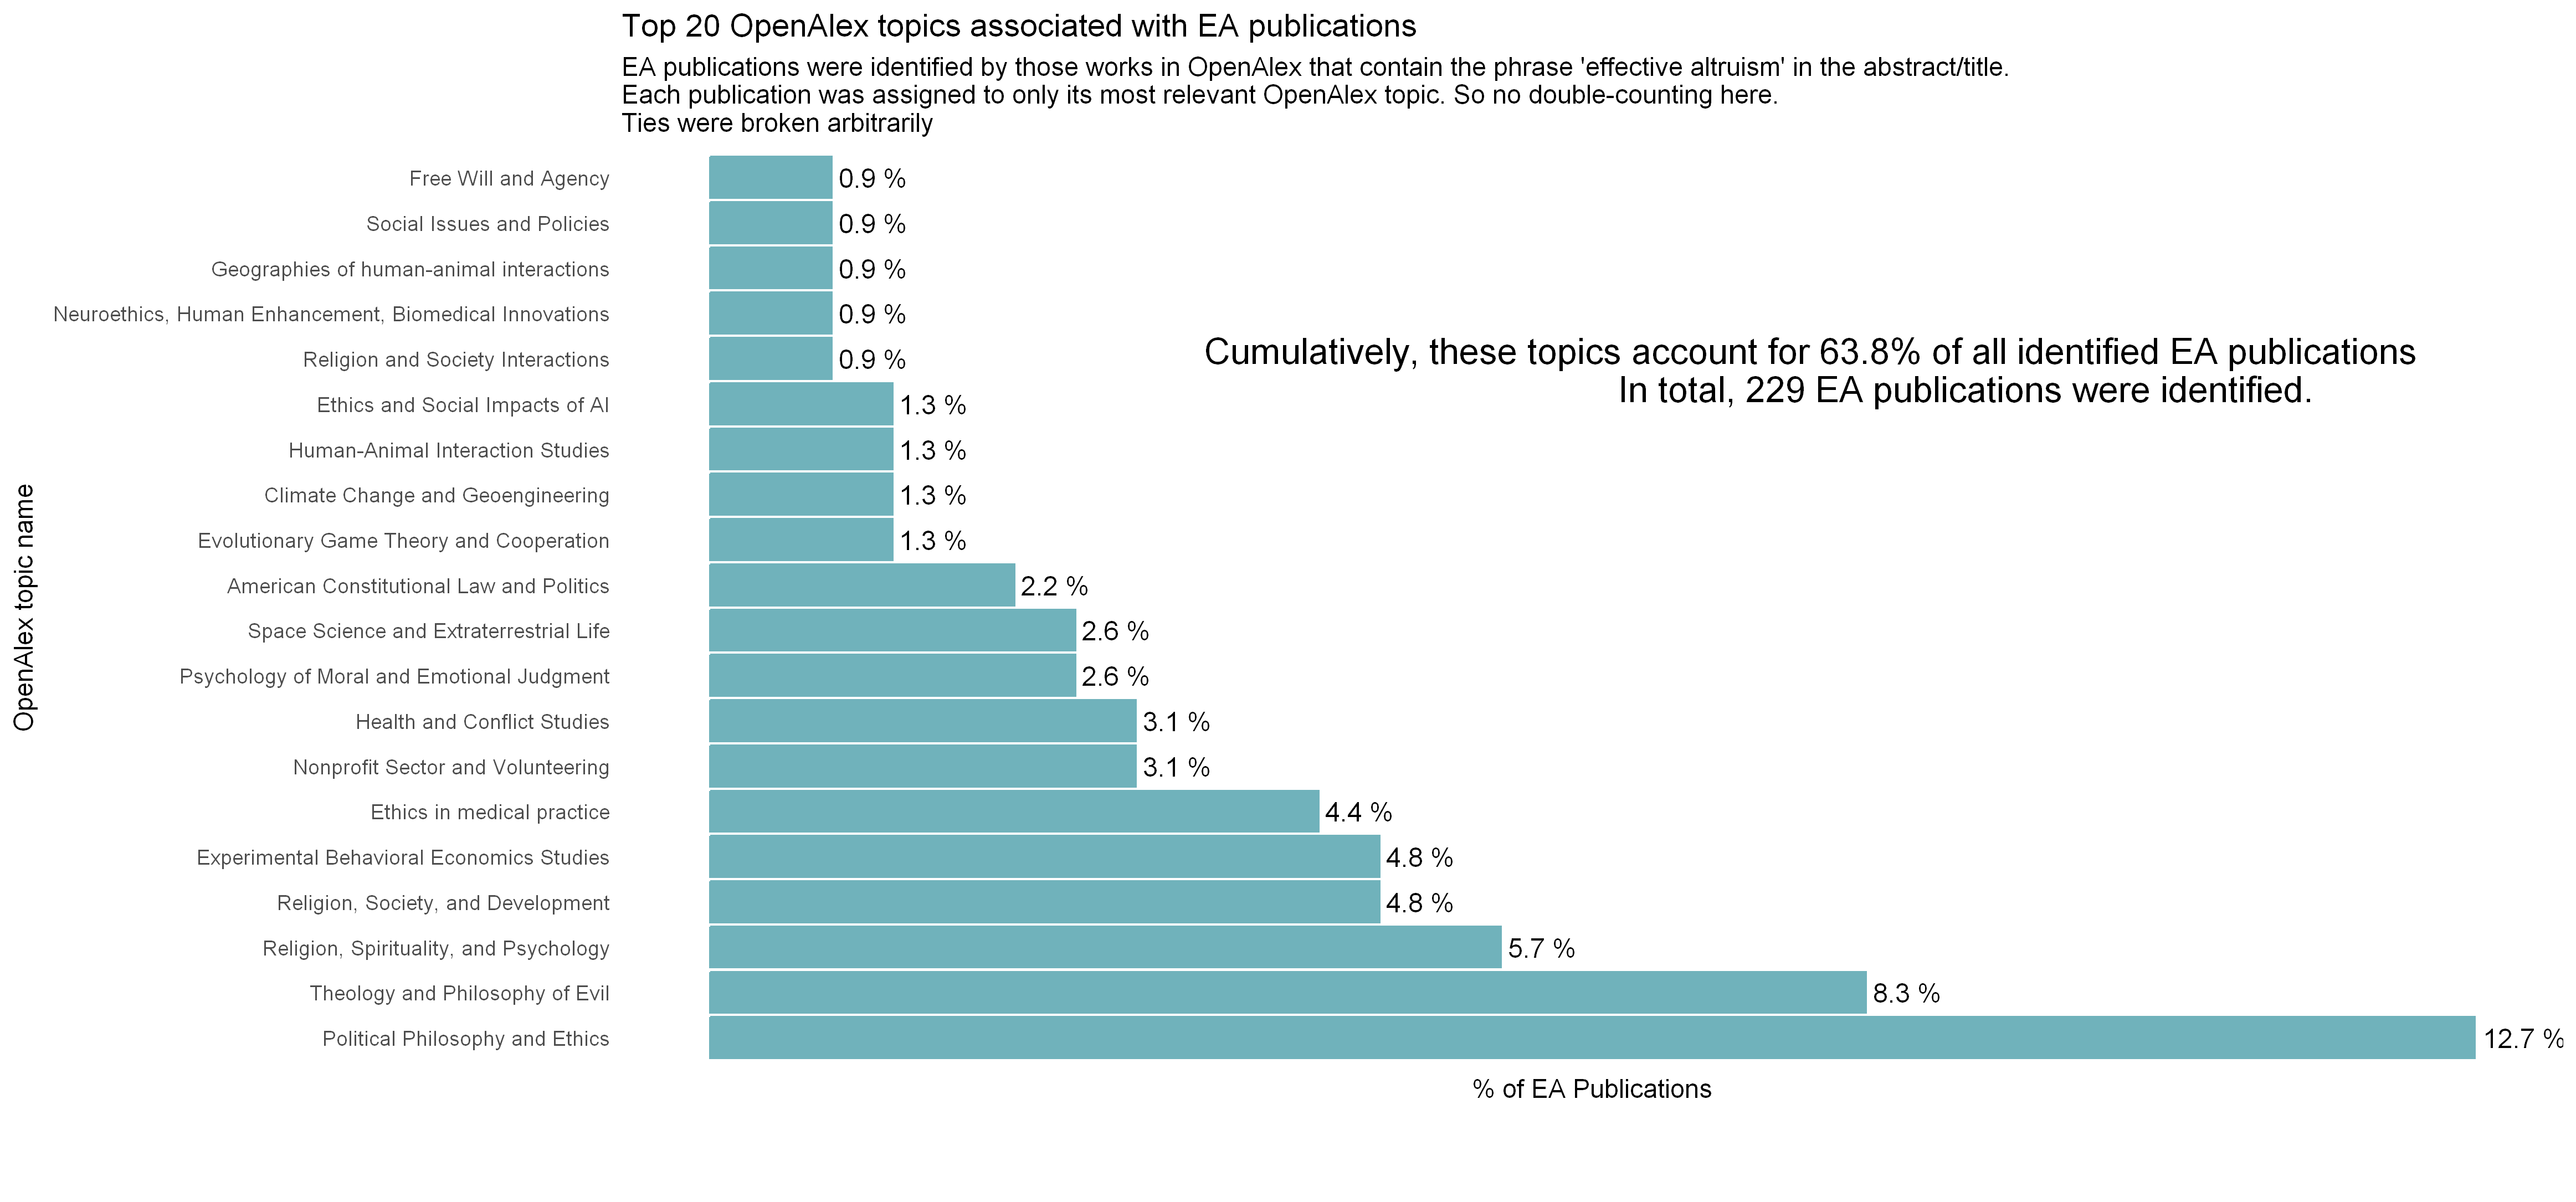

In [ ]:
topic_cnts <- read.csv("./data/topics_cnt.csv")
tot_works <- topic_cnts  |> summarise(sum(ea_wrks_topcnt))  |> pull()
topn=20
plt_data <- topic_cnts |>
    arrange(desc(ea_wrks_topcnt)) |>
    head(topn) |>
    mutate(
        topic_name = factor(topic_name, levels = topic_name),
        ea_wrks_topcnt_perc = 1.0*ea_wrks_topcnt / tot_works
    ) 
plt_data %>%
    ggplot(aes(y = topic_name, x = ea_wrks_topcnt_perc)) +
    geom_col(fill='#70b2bb', color = '#70b2bb') +
    geom_text(aes(label=paste(round(100*ea_wrks_topcnt_perc, 1), '%')), hjust = -0.1) +
        theme_minimal()  +
        labs(y= 'OpenAlex topic name', x = '% of EA Publications', 
            title=sprintf('Top %d OpenAlex topics associated with EA publications', topn),
            subtitle = "EA publications were identified by those works in OpenAlex that contain the phrase 'effective altruism' in the abstract/title.\nEach publication was assigned to only its most relevant OpenAlex topic. So no double-counting here.\nTies were broken arbitrarily",
            caption=sprintf("Cumulatively, these topics account for %.1f%% of all identified EA publications\nIn total, %d EA publications were identified.", 
                            plt_data  |> summarise(sum(ea_wrks_topcnt_perc)*100)  |> pull(),
                            tot_works
                            )) +
        theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(), plot.caption = element_text(size=15, hjust = 0.8, vjust = 100), panel.grid = element_blank())

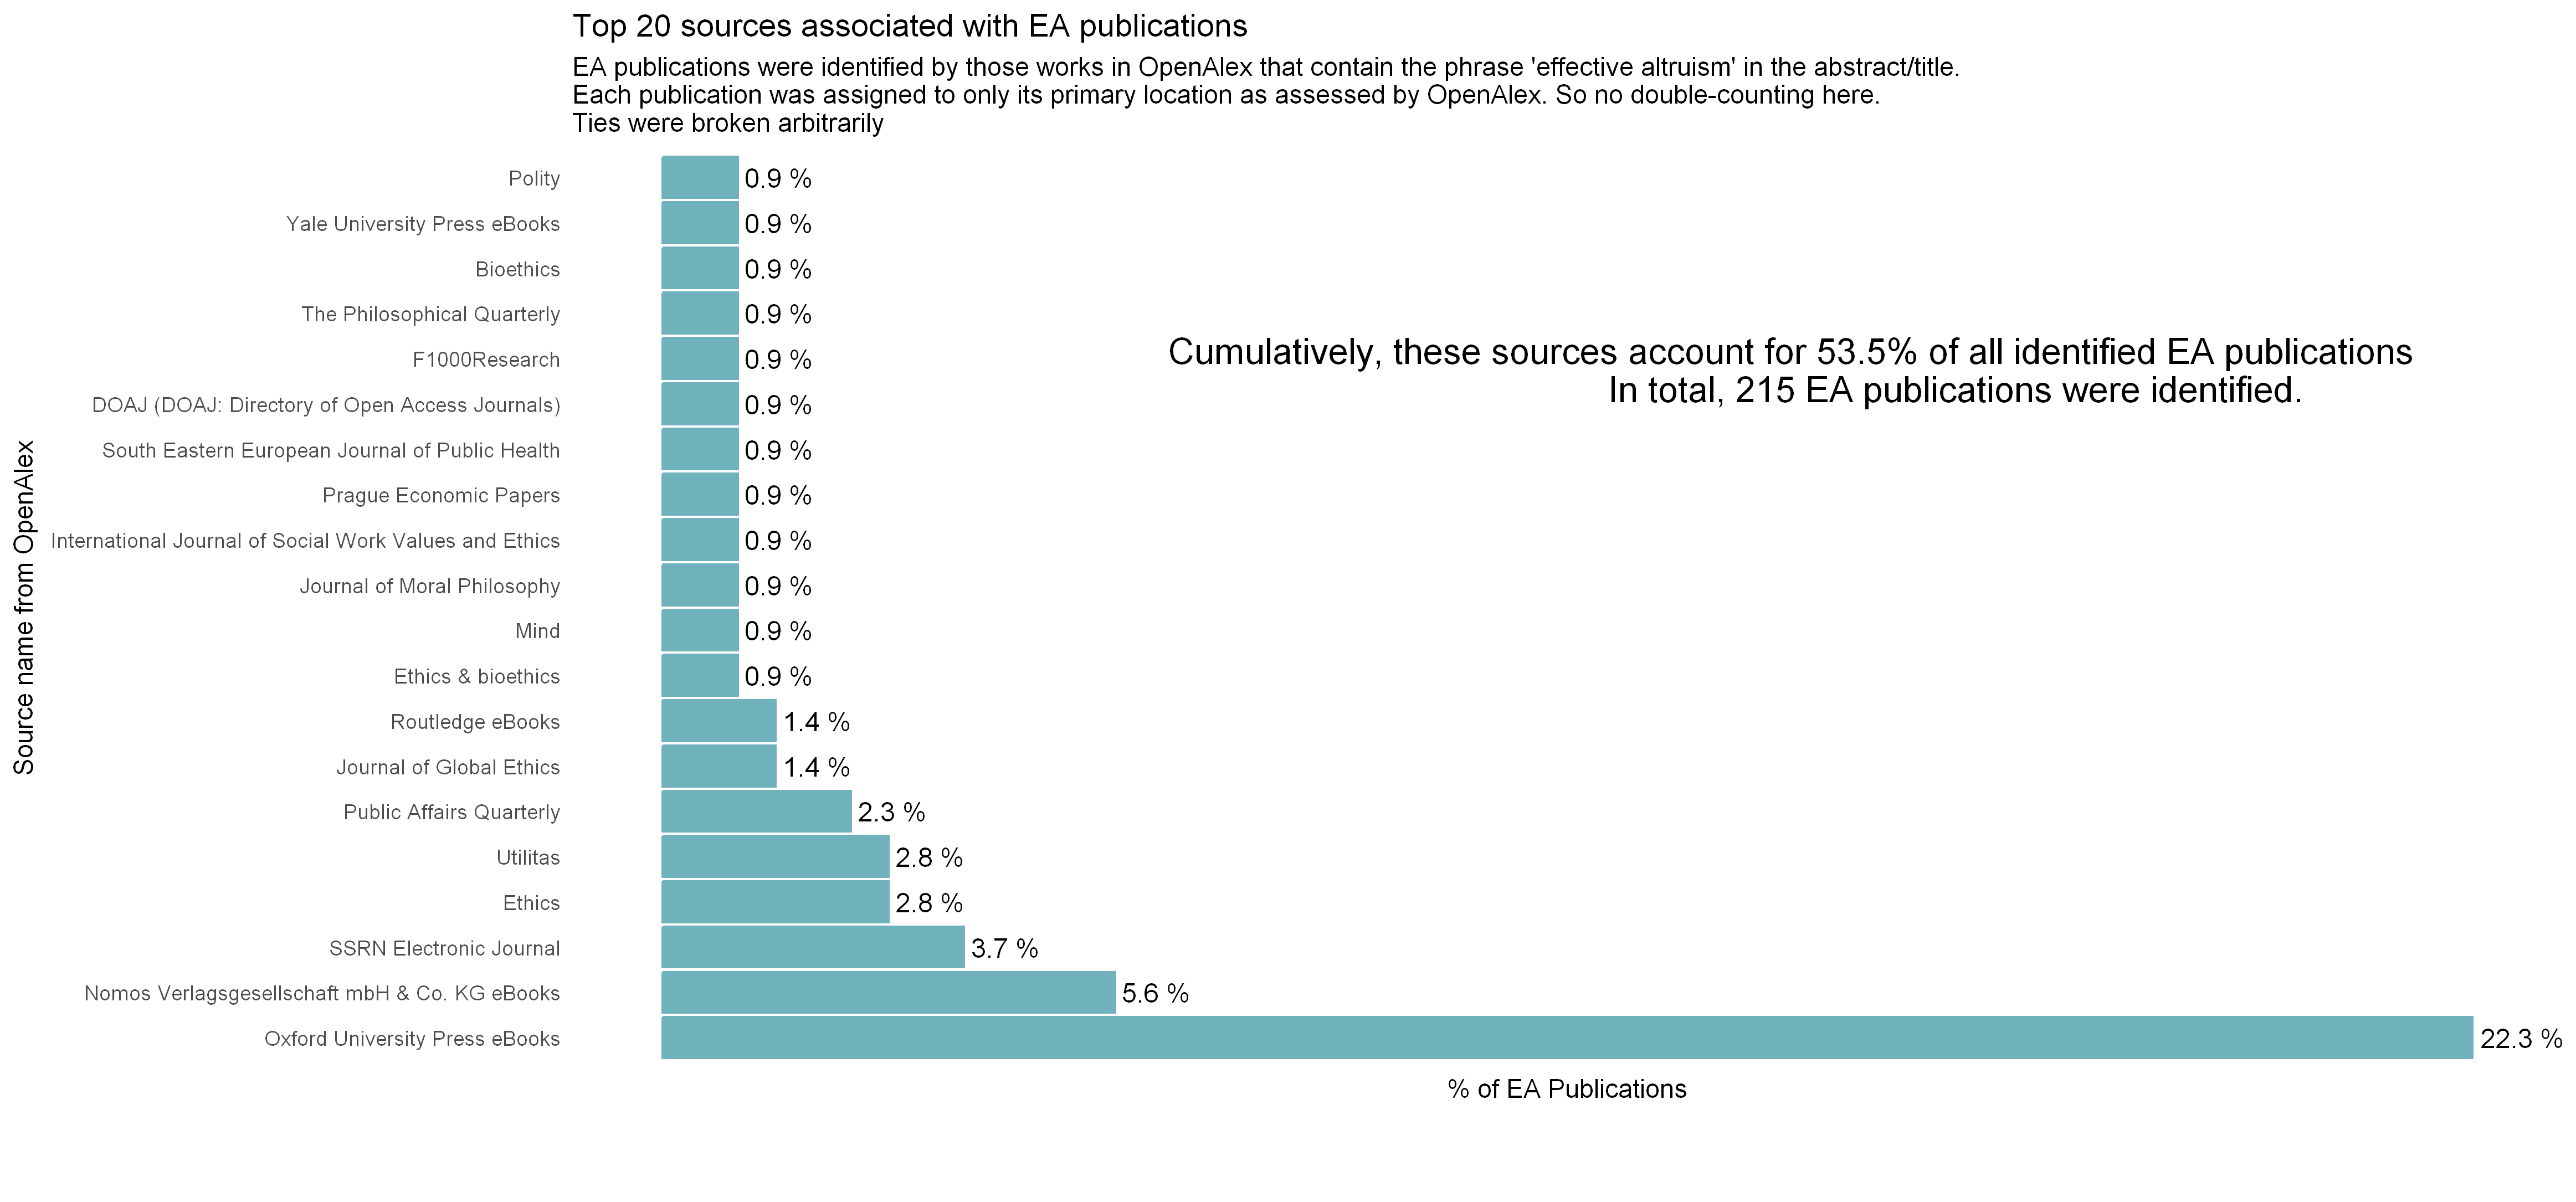

In [ ]:
journ_cnts <- read.csv("./data/journ_cnt.csv")
tot_works <- journ_cnts  |> summarise(sum(ea_wrks_cnt))  |> pull()
topn=20
plt_data <- journ_cnts |>
    arrange(desc(ea_wrks_cnt)) |>
    head(topn) |>
    mutate(
        display_name = factor(display_name, levels = display_name),
        ea_wrks_cnt_perc = 1.0*ea_wrks_cnt / tot_works
    ) 
plt_data %>%
    ggplot(aes(y = display_name, x = ea_wrks_cnt_perc)) +
    geom_col(fill='#70b2bb', color = '#70b2bb') +
    geom_text(aes(label=paste(round(100*ea_wrks_cnt_perc, 1), '%')), hjust = -0.1) +
        theme_minimal()  +
        labs(y= 'Source name from OpenAlex', x = '% of EA Publications', 
            title=sprintf('Top %d sources associated with EA publications', topn),
            subtitle = "EA publications were identified by those works in OpenAlex that contain the phrase 'effective altruism' in the abstract/title.\nEach publication was assigned to only its primary location as assessed by OpenAlex. So no double-counting here.\nTies were broken arbitrarily",
            caption=sprintf("Cumulatively, these sources account for %.1f%% of all identified EA publications\nIn total, %d EA publications were identified.", 
                            plt_data  |> summarise(sum(ea_wrks_cnt_perc)*100)  |> pull(),
                            tot_works
                            )) +
        theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(), plot.caption = element_text(size=15, hjust = 0.8, vjust = 100), panel.grid = element_blank())